In [10]:
import numpy as np
import matplotlib.pyplot as plt
import queue
from geopy.distance import geodesic,distance
"""
加载数据集    latitude longitude
"""
def load_dataset(filename,length):
    r = open(filename, 'r')
    datas = r.readlines()
    list = []
    del (datas[0])
    for i in range(0, len(datas)):
        temp_list = datas[i].split(',')
        temp_list2 = []
        # temp_list2.append(float(temp_list[0]))
        temp_list2.append(float(temp_list[1]))
        temp_list2.append(float(temp_list[2]))
        list.append((float(temp_list[1]), float(temp_list[2])))
        if i > length:
            break
    return list
"""
计算两个向量的距离
"""
def dist(vec1, vec2):
   # dist = distance(vec1, vec2).miles#两个点通过经纬度计算距离
    dist = np.sqrt(np.sum(np.square(np.array(vec1) - np.array(vec2)))) #计算欧式距离
    return dist
"""
得到邻域内所有样本点的Id
data: 样本点
core_point_id  核心点
radius  半径
"""
def neighbor_points(data, core_point, radius):
    points = []
    for i in range(0,len(data)):
        #计算 每个点与核心点的距离  如果小于半径  则加入此簇
        if type(core_point).__name__ == 'tuple':
            if dist(data[i], core_point) < radius:
                points.append(data[i])
        else:
            if dist(data[i], data[core_point]) < radius:
                points.append(data[i])
    return points

"""
扫描整个数据集，为每个数据集打上核心点，
data: 样本集
radius: 半径
minPts:  最小局部密度
"""
import random
def dbscan(datas, radius, minPts):
    # 聚类个数
    k = 0
    # 核心对象集合
    omega = set()
    # 未访问样本集合
    not_visit = set(datas)
    # 聚类结果
    cluster = dict()
    cluster_core = []
    # 遍历样本集找出所有核心对象
    for point_id in range(0,len(datas)):
        # 计算以point_id为核心的点 有多少  以point_id为圆心   以radius为半径
        points = neighbor_points(datas, point_id, radius)
        if len(points) >= minPts:
            omega.add(datas[point_id])
    #遍历核心对象的集合
    while len(omega):
        # 记录当前未访问样本集合
        not_visit_old = not_visit
        # 随机选取一个核心对象core
        core = list(omega)[random.randint(0, len(omega)-1)]
        print(core)
        cluster_core.append(core)
        not_visit  = not_visit - set(core)
        # 初始化队列，存放核心对象或样本
        core_deque = queue.Queue()
        core_deque.put(core)
        while not core_deque.empty():
            coreq = core_deque.get()
            # 找出以coreq邻域内的样本点
            coreq_neighborhood = neighbor_points(datas, coreq, radius)
            # 若coreq为核心对象，求其邻域内且未被访问过的样本找出
            if len(coreq_neighborhood) >= minPts:
                intersection = set()
                for i in coreq_neighborhood:
                    if i in  list(not_visit) :
                        intersection.add(i)
                #将领域内未被访问过的样本找到 加入队列  对聚类进行扩散
                for i in list(intersection):
                    core_deque.put(i)
                    #将这些点标记为已访问
                not_visit  = not_visit - intersection
        #当队列再次为空时，一个聚类已经形成
        #这个聚类内的点
        Ck = not_visit_old - not_visit
        omega = omega - Ck
        cluster[k] = list(Ck)
        k += 1
    return cluster,cluster_core

def show_dataset(dataset):
    for item in dataset:
        plt.scatter(item[0], item[1], c='red', alpha=1, marker='+')
    plt.title("Dataset")
    print('Dataset done')
    plt.show()

def plotRes( clusterRes):

    scatterColors = ['black', 'blue', 'green', 'yellow', 'red', 'purple', 'orange', 'brown','m', 'fuchsia', 'crimson', 'dodgerblue', 'lime', 'coral', 'peru', 'khaki','black', 'blue', 'green', 'yellow', 'red', 'purple', 'orange', 'brown','m', 'fuchsia', 'crimson', 'dodgerblue', 'lime', 'coral', 'peru', 'khaki','black', 'blue', 'green', 'yellow', 'red', 'purple', 'orange', 'brown','m', 'fuchsia', 'crimson', 'dodgerblue', 'lime', 'coral', 'peru', 'khaki']
    for key in clusterRes.keys():
        for item in clusterRes[key]:

                plt.scatter(item[0], item[1], c=scatterColors[key], alpha=1, marker='+')
    plt.title("DBSCAN Clustering")
    plt.show()

In [11]:
# #聚类平均距离
def avg_dis(cluster):
    sum = 0.0
    for i in cluster:
        for j in cluster:
            sum += dist(i,j)
    l = len(cluster)#聚类点的个数
    return sum/(l*(l-1))
    
        
    
def compute_Rij(i,j,k,cluster_res,cluster_core):
    avg_ci = avg_dis(cluster_res[i])
    avg_cj = avg_dis(cluster_res[j])                       
    dcen = dist(cluster_core[i],cluster_core[j])#两个聚类核心点的距离
    res = (avg_ci +avg_cj) /dcen
    return res


def compute_max(index ,cluster_res,k,cluster_core):
    list_r = []
    for j in range(0,k):
        if index != j:
            temp = compute_Rij(index, j, k, cluster_res, cluster_core)
            list_r.append(temp)
    return max(list_r)
    
def computer_db_index(cluster_res,cluster_core):
    k  = len(cluster_core) #聚类总数
    sigma_R = 0.0
    for i in range(0,k):
        sigma_R += compute_max(i,cluster_res,k,cluster_core)
    dbi = float(sigma_R)/float(k)
    return dbi
#2000  0.003, 20    16簇
#2000  0.0025, 20    18
#3000  0.0025, 20 17簇
#3000  0.002, 20 26簇
#5000   0.0015, 25  44簇# #聚类平均距离

500个点   半径0.003   minpot=10


(-10.90427461, -37.04804767)


(-10.94738018, -37.07133287)


(-10.9213142, -37.04645695)


(-10.89615689, -37.0531224)


(-10.926169999999999, -37.102470000000004)
(-10.89711667, -37.07969833)


(-10.94419909, -37.08799875)
(-10.90847375, -37.07221199)
(-10.94578166, -37.04610127)


最终分为 9 个簇


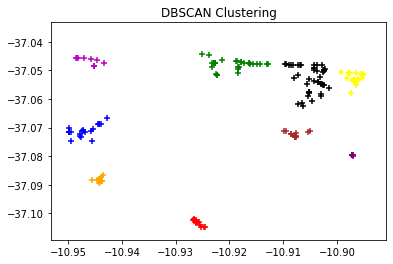

簇的db指数为 0.42714836971543685


In [12]:

data_list = load_dataset('Experiment1/data/temp.csv',500)
print('500个点'," ","半径0.003"," ",'minpot=10')
clusterRes,cluster_core = dbscan(data_list, 0.003, 10)
print('最终分为',len(clusterRes.keys()),'个簇')
plotRes(clusterRes)
dbi = computer_db_index(clusterRes,cluster_core)
print('簇的db指数为',dbi)

2000个点   半径0.003   minpot=20


(-10.91116882, -37.04779298)


(-10.91871178, -37.0688318)


(-10.9225328, -37.0947912)


(-10.946092, -37.07143151)


(-10.95465304, -37.05307221)


(-10.92381307, -37.10144377)


(-10.98278258, -37.05403212)


(-10.92679884, -37.08050395)


(-10.941723800000002, -37.07856411)


(-10.89694333, -37.079645)


(-10.94339108, -37.06114982)


(-10.96537333, -37.04236167)


(-10.97584374, -37.0471631)


(-10.9433771, -37.08908034)


(-10.97005395, -37.05544473)


(-10.93518872, -37.062843799999996)


最终分为 16 个簇


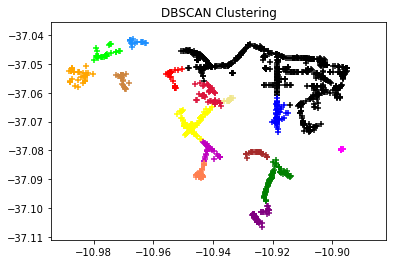

簇的db指数为 0.7688078406398233


In [13]:

data_list = load_dataset('Experiment1/data/temp.csv',2000)
print('2000个点'," ","半径0.003"," ",'minpot=20')
clusterRes,cluster_core = dbscan(data_list, 0.003, 20)
print('最终分为',len(clusterRes.keys()),'个簇')
plotRes(clusterRes)
dbi = computer_db_index(clusterRes,cluster_core)
print('簇的db指数为',dbi)

2000个点   半径0.0025   minpot=20


(-10.94402329, -37.05105096)


(-10.90530828, -37.05905009)


(-10.91845177, -37.05337604)


(-10.90771697, -37.073026399999996)


(-10.92640667, -37.1022)


(-10.914225, -37.08876667)


(-10.97584008, -37.04717088)


(-10.897135, -37.07962333)


(-10.91876231, -37.07035311)


(-10.94423757, -37.06863605)


(-10.89615689, -37.0531224)


(-10.94367587, -37.08864231)


(-10.93054785, -37.04621469)


(-10.95431153, -37.05288464)


(-10.93932497, -37.06376424)


(-10.94120926, -37.05946102)


(-10.9417208, -37.07949716)


(-10.98414212, -37.05447072)


最终分为 18 个簇


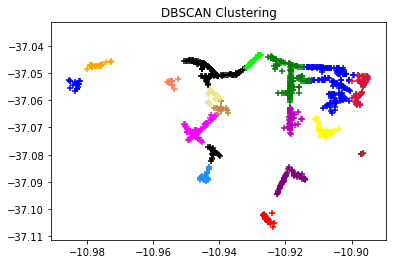

簇的db指数为 0.6601676805658377


In [14]:
#2000  0.0025, 20    18
data_list = load_dataset('Experiment1/data/temp.csv',2000)
print('2000个点'," ","半径0.0025"," ",'minpot=20')
clusterRes,cluster_core = dbscan(data_list, 0.0025, 20)
print('最终分为',len(clusterRes.keys()),'个簇')
plotRes(clusterRes)
dbi = computer_db_index(clusterRes,cluster_core)
print('簇的db指数为',dbi)

2000个点   半径0.002   minpot=20


(-10.94738018, -37.07133287)


(-10.90502869, -37.06230197)


(-10.9546446, -37.05303772)


(-10.89712333, -37.07968167)


(-10.92270667, -37.0473)


(-10.90213324, -37.05541074)


(-10.89669953, -37.05336406)


(-10.9075945, -37.07307496)


(-10.94542849, -37.04617779)


(-10.97714195, -37.04750332)


(-10.91871482, -37.07059338)


(-10.91855097, -37.0546007)


(-10.89735271, -37.05797875)


(-10.91056265, -37.04803685)


(-10.94340131, -37.08891325)


(-10.92616008, -37.10265139)


(-10.92072642, -37.08992047)


(-10.91845131, -37.04761147)


(-10.90420045, -37.04857642)


(-10.91564459, -37.08782872)


(-10.93134868, -37.04738268)


(-10.91480667, -37.052755)


最终分为 22 个簇


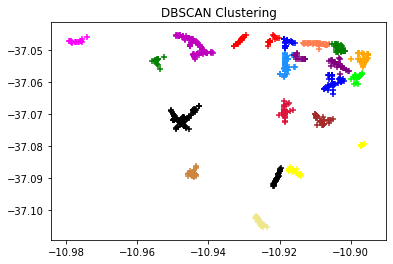

簇的db指数为 0.5153799120716268


In [15]:
#2000  0.002, 20    18
data_list = load_dataset('Experiment1/data/temp.csv',2000)
print('2000个点'," ","半径0.002"," ",'minpot=20')
clusterRes,cluster_core = dbscan(data_list, 0.002, 20)
print('最终分为',len(clusterRes.keys()),'个簇')
plotRes(clusterRes)
dbi = computer_db_index(clusterRes,cluster_core)
print('簇的db指数为',dbi)

2000个点   半径0.002   minpot=15


(-10.90366065, -37.05436829999999)


(-10.89686294, -37.05354465)


(-10.91866695, -37.0688564)


(-10.91012589, -37.06381172)


(-10.94696086, -37.07147013)


(-10.90442535, -37.04814392)


(-10.89757658, -37.05817478)


(-10.91797614, -37.05739711)


(-10.90441755, -37.06044103)


(-10.95455757, -37.052767200000005)


(-10.90772459, -37.07324626)


(-10.922715, -37.04712333)


(-10.94389148, -37.05275402)


(-10.89710667, -37.07973)


(-10.94343039, -37.08916179)


(-10.92574353, -37.08054311)


(-10.92548818, -37.10390397)


(-10.93175304, -37.04802048)


(-10.92084793, -37.09012921)


(-10.90810667, -37.05173333)


(-10.94062398, -37.05822958)


(-10.93934139, -37.06274211)


(-10.941913099999999, -37.08016328)


(-10.916605, -37.08805333)


(-10.93499496, -37.05021467)


(-10.97584423, -37.04716248)


(-10.96738833, -37.04269)


(-10.97055754, -37.05384824)


(-10.92425796, -37.04387439)


(-10.98372957, -37.05326019)


最终分为 30 个簇


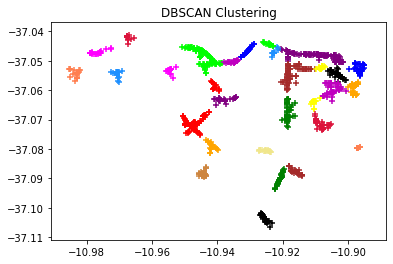

簇的db指数为 0.6917199948841348


In [16]:

data_list = load_dataset('Experiment1/data/temp.csv',2000)
print('2000个点'," ","半径0.002"," ",'minpot=15')
clusterRes,cluster_core = dbscan(data_list, 0.002, 15)
print('最终分为',len(clusterRes.keys()),'个簇')
plotRes(clusterRes)
dbi = computer_db_index(clusterRes,cluster_core)
print('簇的db指数为',dbi)

2000个点   半径0.002   minpot=15


(-10.95455757, -37.052767200000005)


(-10.9077618, -37.07321398)


(-10.91845177, -37.05337604)


(-10.92278196, -37.04734347)


(-10.90493773, -37.06060923)


(-10.91871482, -37.07059338)


(-10.93460012, -37.05023121)


(-10.90348491, -37.05422527)


(-10.94141139, -37.05052379999999)


(-10.94721781, -37.07091015)


(-10.94190519, -37.08004182)


(-10.90783923, -37.04807406)


(-10.897115, -37.079745)


(-10.92118769, -37.09078109)


(-10.8977761, -37.05829136)


(-10.90828167, -37.05265833)


(-10.92512667, -37.10481667)


(-10.93049052, -37.04655763)


(-10.94388244, -37.08885081)


(-10.97551333, -37.04656)


(-10.89671013, -37.05339651)


(-10.91794175, -37.04699362)


(-10.916605, -37.08805333)


(-10.9403891, -37.05829088)


(-10.93936187, -37.06374669)


(-10.91480667, -37.052755)


(-10.98278258, -37.05403212)


(-10.91037788, -37.06479622)


(-10.92535048, -37.08042683)


最终分为 29 个簇


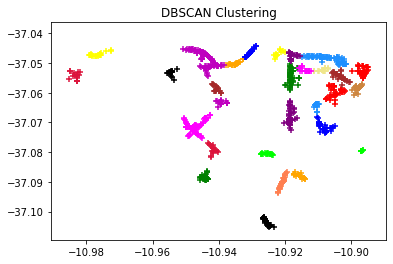

簇的db指数为 0.649662437039423


In [17]:

data_list = load_dataset('Experiment1/data/temp.csv',2000)
print('2000个点'," ","半径0.002"," ",'minpot=15')
clusterRes,cluster_core = dbscan(data_list, 0.002, 17)
print('最终分为',len(clusterRes.keys()),'个簇')
plotRes(clusterRes)
dbi = computer_db_index(clusterRes,cluster_core)
print('簇的db指数为',dbi)

2000个点   半径0.0017   minpot=20


(-10.94390863, -37.06926429)


(-10.91811121, -37.05517797)


(-10.89714, -37.07969333)


(-10.89686733, -37.05350894)


(-10.90231748, -37.05029076)


(-10.92317167, -37.04867167)


(-10.90760566, -37.07195547)


(-10.90356704, -37.06012396)


(-10.91518566, -37.08836594)


(-10.94786159, -37.07284255)


(-10.94315425, -37.05103445)


(-10.94340131, -37.08891325)


(-10.90366, -37.05435948)


(-10.94549765, -37.04634277)


(-10.89768076, -37.058279299999995)


(-10.90934486, -37.04801046)


(-10.92662572, -37.10231703)


(-10.91930848, -37.06974579)


(-10.955252999999999, -37.0534929)


(-10.92089667, -37.09023)


(-10.97710904, -37.04750804)


最终分为 21 个簇


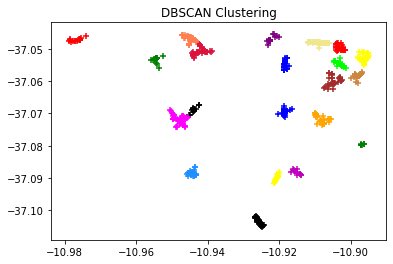

簇的db指数为 0.42745177867378803


In [19]:
#3000  0.0025, 20 17簇
#3000  0.002, 20 26簇
#5000   0.0015, 25  44簇# #聚类平均距离
data_list = load_dataset('Experiment1/data/temp.csv',2000)
print('2000个点'," ","半径0.0017"," ",'minpot=20')
clusterRes,cluster_core = dbscan(data_list, 0.0017, 20)
print('最终分为',len(clusterRes.keys()),'个簇')
plotRes(clusterRes)
dbi = computer_db_index(clusterRes,cluster_core)
print('簇的db指数为',dbi)

3000个点   半径0.0017   minpot=20


(-10.94488887, -37.04645904)


(-10.9024154, -37.04992892)


(-10.94982137, -37.07167614)


(-10.89684478, -37.05350241)


(-10.91279833, -37.05271833)


(-10.90776883, -37.07326307)


(-10.92635, -37.10244333)


(-10.91792517, -37.06924827)


(-10.90297727, -37.05903632)


(-10.94077575, -37.07936)


(-10.97574333, -37.047095)


(-10.94394182, -37.08949531)


(-10.89708667, -37.07974)


(-10.93473136, -37.05028841)


(-10.92072642, -37.08992047)


(-10.96771551, -37.04169105)


(-10.93134868, -37.04738268)


(-10.89735271, -37.05797875)


(-10.91861719, -37.05800347)


(-10.94062398, -37.05822958)


(-10.9227925, -37.04731602)


(-10.92620254, -37.08044437)


(-10.98293633, -37.05408188)


(-10.94338843, -37.06091866)


(-10.93795605, -37.06293748)


(-10.95581651, -37.05337069)


(-10.97067294, -37.05379517)


(-10.92303774, -37.04480885)


(-10.91037424, -37.06384896)


(-10.91855532, -37.0645434)


(-10.91495333, -37.08899333)


最终分为 31 个簇


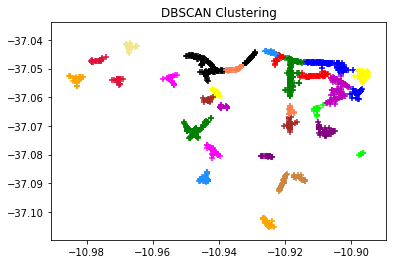

簇的db指数为 0.575579216305195


In [20]:
#3000  0.0025, 20 17簇

#3000  0.002, 20 26簇

#5000   0.0015, 25  44簇# #聚类平均距离

data_list = load_dataset('Experiment1/data/temp.csv',3000)
print('3000个点'," ","半径0.0017"," ",'minpot=20')
clusterRes,cluster_core = dbscan(data_list, 0.0017, 20)
print('最终分为',len(clusterRes.keys()),'个簇')
plotRes(clusterRes)
dbi = computer_db_index(clusterRes,cluster_core)
print('簇的db指数为',dbi)

3000个点   半径0.0015   minpot=25


(-10.90849833, -37.052605)


(-10.91418833, -37.08882333)


(-10.93908033, -37.06297981)


(-10.94116053, -37.05018967)


(-10.90297148, -37.05840861)


(-10.89684201, -37.05356829)


(-10.94523651, -37.04638459)


(-10.90771621, -37.07303243)


(-10.95443078, -37.05304593)


(-10.91848922, -37.04832086)


(-10.97584207, -37.04716897)


(-10.926205, -37.10234833)


(-10.94778207, -37.07323872)


(-10.90232844, -37.05039233)


(-10.90698404, -37.04826304)


(-10.96776304, -37.04165778)


(-10.91865205, -37.06996072)


(-10.89783221, -37.08008072)


(-10.92028167, -37.08961667)


(-10.98278258, -37.05403212)


(-10.92284386, -37.04740164)


(-10.91805938, -37.07302097)


(-10.93220215, -37.04813782)


(-10.93369918, -37.04972937)


(-10.91851866, -37.05669263)


(-10.95253669, -37.05899601)


(-10.9435854, -37.08861281)


(-10.91043138, -37.06633609)


(-10.9243918, -37.08056434)


(-10.97056, -37.05371667)


(-10.94239054, -37.07782323)


(-10.98720333, -37.05178)


(-10.94273035, -37.06080869)


(-10.91048471, -37.06414258)


(-10.94424014, -37.06863994)


(-10.93366932, -37.05325487)


(-10.95654706, -37.06937055)


(-10.92384811, -37.04462568)


(-10.93817605, -37.08192953)


(-10.91143227, -37.05271666)


(-10.92850483, -37.04377516)


(-10.90845521, -37.08610801)


(-10.93492341, -37.06276569)


(-10.94268457, -37.05650941)


最终分为 44 个簇


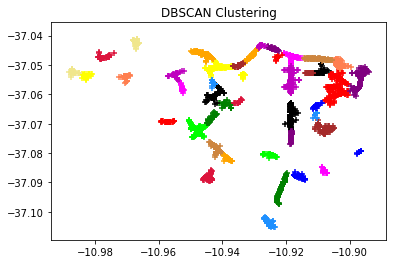

簇的db指数为 0.6683937110846576


In [21]:
#5000   0.0015, 25  44簇#
data_list = load_dataset('Experiment1/data/temp.csv',5000)
print('3000个点'," ","半径0.0015"," ",'minpot=25')
clusterRes,cluster_core = dbscan(data_list, 0.0015, 25)
print('最终分为',len(clusterRes.keys()),'个簇')
plotRes(clusterRes)
dbi = computer_db_index(clusterRes,cluster_core)
print('簇的db指数为',dbi)